# Ex 2 - Transfer learning
##### Group: 9
###### Student 1: Sinem Dere 
###### Student 2: Fabian Gröger
###### Student 3: Andrin Bürli

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.metrics import accuracy_score

# GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [4]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


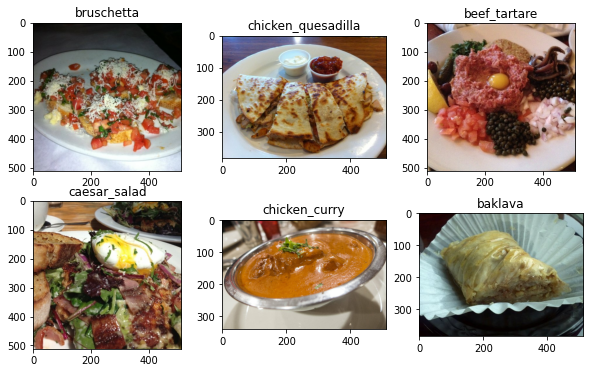

In [5]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    #plt.axis("off")

## Resize and normalize

In [6]:
# Normalize the images
def norm(img, label):
    return tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(img, tf.float32)), label

train_ds = train_ds.map(norm)
validation_ds = validation_ds.map(norm)
test_ds = test_ds.map(norm)

In [7]:
# TODO Resize the images in the training, validation and test set
def resize(img, label, size=224):
    return tf.image.resize(img[tf.newaxis], [size, size])[0], label

train_ds = train_ds.map(lambda img, label: resize(img, label))
validation_ds = validation_ds.map(lambda img, label: resize(img, label))
test_ds = test_ds.map(lambda img, label: resize(img, label))

In [8]:
# One hot encode the labels
def one_hot(img, label):
    return img, tf.one_hot([label], N_CLASSES)[0]

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

In [9]:
# batch dataset
batch_size = 32

train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [10]:
# repeat train and valdatasets
train_ds = train_ds.repeat()
validation_ds = validation_ds.repeat()

In [11]:
steps_per_epoch = (101 * N_CLASSES) // batch_size

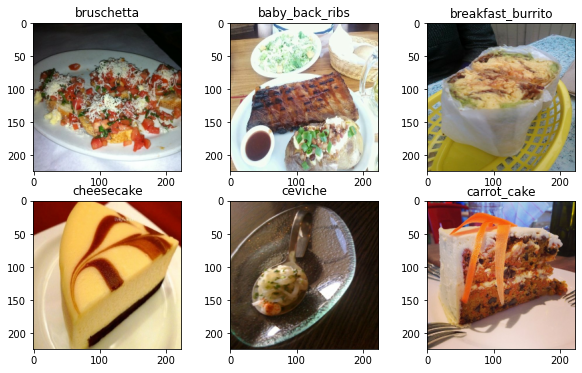

In [12]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    image = image.numpy()
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow((image[0] - image[0].min()) / (image[0].max() - image[0].min()))
    plt.title(CLASS_NAMES[np.argmax(label[0])])
    #plt.axis("off")

## Data-Augmentation

In [13]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [14]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling="max") # using max pooling over the channel dimension

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
features = base_model(inputs)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(features)

model1 = keras.Model(inputs, outputs)

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 837 ms, sys: 2.4 ms, total: 839 ms
Wall time: 831 ms


In [15]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics="accuracy")

# Optional: Define and use callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode="auto")

step1_history = model1.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=steps_per_epoch // 10, callbacks=[checkpoint], epochs=30) # You should us a smaller learning rate: 1e-6

Epoch 1/30
63/63 [==============================] - 9s 93ms/step - loss: 5.7118 - accuracy: 0.1096 - val_loss: 3.2218 - val_accuracy: 0.2812

Epoch 00001: val_accuracy improved from -inf to 0.28125, saving model to model-001.h5
Epoch 2/30
63/63 [==============================] - 5s 80ms/step - loss: 3.1276 - accuracy: 0.3572 - val_loss: 1.9894 - val_accuracy: 0.4948

Epoch 00002: val_accuracy improved from 0.28125 to 0.49479, saving model to model-002.h5
Epoch 3/30
63/63 [==============================] - 5s 79ms/step - loss: 2.3638 - accuracy: 0.4402 - val_loss: 1.7661 - val_accuracy: 0.5573

Epoch 00003: val_accuracy improved from 0.49479 to 0.55729, saving model to model-003.h5
Epoch 4/30
63/63 [==============================] - 5s 80ms/step - loss: 2.3075 - accuracy: 0.4838 - val_loss: 2.0341 - val_accuracy: 0.5208

Epoch 00004: val_accuracy did not improve from 0.55729
Epoch 5/30
63/63 [==============================] - 5s 80ms/step - loss: 2.0300 - accuracy: 0.5369 - val_loss: 1.

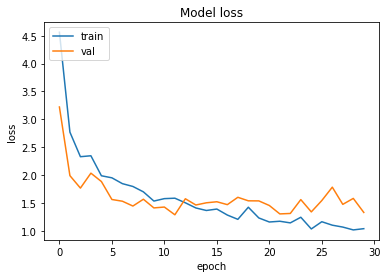

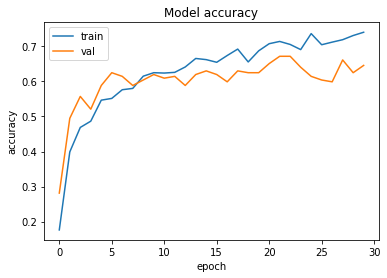

In [16]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')
plot_history(step1_history, 'accuracy')

The model seems to converge with high bias and low variance. Adding more hidden layers might help to reduce the bias problem.

#### Step 1.1 Try out different input shapes
During the discussion with the team we had the question, that if we change the input shape would the performance also change? Here we wanted to try this out.

-------------------- Shape: 96 --------------------


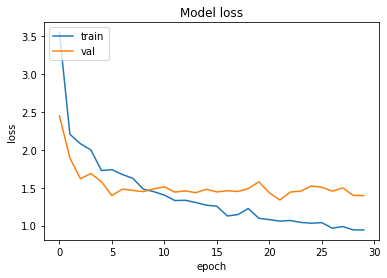

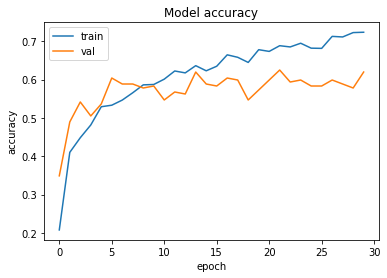

-------------------- Shape: 128 --------------------


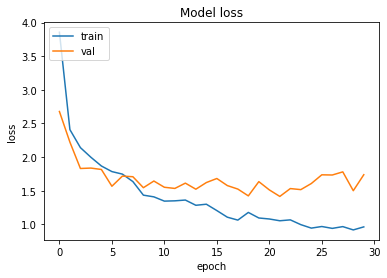

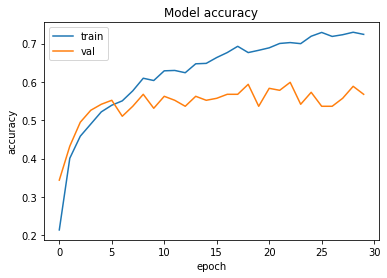

-------------------- Shape: 160 --------------------


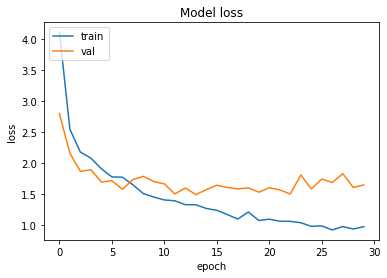

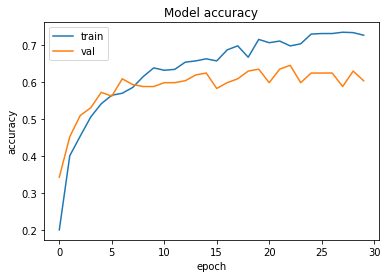

-------------------- Shape: 192 --------------------


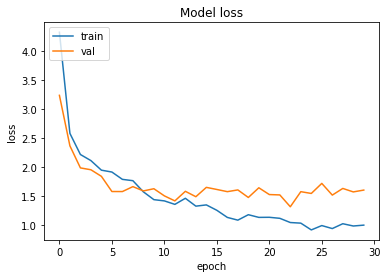

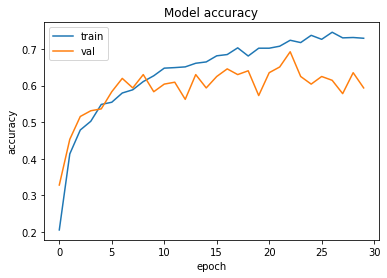

-------------------- Shape: 224 --------------------


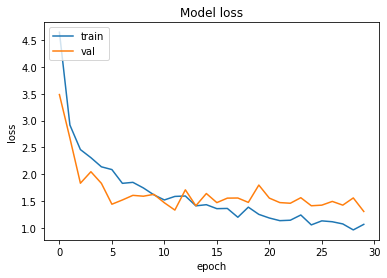

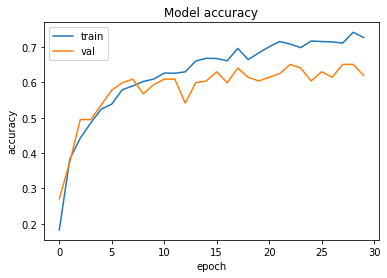

In [17]:
diff_shapes = [96, 128, 160, 192, 224]

for inp_shape in diff_shapes:
    print('-'*20 + ' Shape: {} '.format(inp_shape) + '-'*20)
    
    # load data
    (t_ds, v_ds, te_ds), info = tfds.load(
        "food101",
        split=["train", "validation[:50%]", "validation[50%:]"],
        as_supervised=True,
        with_info=True
    )
    
    # Filter the dataset to keep the first 20 classes only.
    N_CLASSES = 20
    CLASS_NAMES = info.features['label'].names[:N_CLASSES]

    t_ds = t_ds.filter(lambda img, label: label < N_CLASSES)
    v_ds = v_ds.filter(lambda img, label: label < N_CLASSES)

    # normalize
    t_ds = t_ds.map(norm)
    v_ds = v_ds.map(norm)
    
    # resize
    t_ds = t_ds.map(lambda img, lbl: resize(img, lbl, size=inp_shape))
    v_ds = v_ds.map(lambda img, lbl: resize(img, lbl, size=inp_shape))
    
    # one hot
    t_ds = t_ds.map(one_hot)
    v_ds = v_ds.map(one_hot)
    
    # batch 
    t_ds = t_ds.batch(batch_size)
    v_ds = v_ds.batch(batch_size)
    
    # repeat
    t_ds = t_ds.repeat()
    v_ds = v_ds.repeat()
    
    # model
    tf.keras.backend.clear_session()
    base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, 
                                                   input_shape=(inp_shape, inp_shape, 3), pooling="max")
    base_model.trainable = False

    # Create the model structure
    inputs = tf.keras.layers.Input(shape=(inp_shape, inp_shape, 3))
    features = base_model(inputs)
    outputs = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(features)
    model1 = keras.Model(inputs, outputs)
    
    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                   loss="categorical_crossentropy", metrics="accuracy")
    step1_history = model1.fit(t_ds, 
                               steps_per_epoch=steps_per_epoch, 
                               validation_data=v_ds, 
                               validation_steps=steps_per_epoch // 10, 
                               epochs=30, 
                               verbose=0)
    
    plot_history(step1_history, 'loss')
    plot_history(step1_history, 'accuracy')

### Step 2: Fine-Tune the whole model

In [18]:
%%time

base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling="max") # using max pooling over the channel dimension

# Freeze the base_model
base_model.trainable = True

# Create the model structure
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
features = base_model(inputs)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(features)

model2 = keras.Model(inputs, outputs)

model2.summary()

# Compile the model again
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics="accuracy")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                25620     
Total params: 2,283,604
Trainable params: 2,249,492
Non-trainable params: 34,112
_________________________________________________________________
CPU times: user 773 ms, sys: 3.59 ms, total: 777 ms
Wall time: 768 ms


In [19]:
# Retrain the model
step2_history = model2.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=steps_per_epoch // 10, callbacks=[checkpoint], epochs=300) # You should us a smaller learning rate: 1e-6

Epoch 1/300
63/63 [==============================] - 12s 145ms/step - loss: 11.3348 - accuracy: 0.0526 - val_loss: 9.9213 - val_accuracy: 0.0625

Epoch 00001: val_accuracy did not improve from 0.67188
Epoch 2/300
63/63 [==============================] - 9s 135ms/step - loss: 10.6995 - accuracy: 0.0556 - val_loss: 9.8080 - val_accuracy: 0.0625

Epoch 00002: val_accuracy did not improve from 0.67188
Epoch 3/300
63/63 [==============================] - 9s 135ms/step - loss: 10.2366 - accuracy: 0.0536 - val_loss: 9.6788 - val_accuracy: 0.0625

Epoch 00003: val_accuracy did not improve from 0.67188
Epoch 4/300
63/63 [==============================] - 9s 139ms/step - loss: 10.0292 - accuracy: 0.0627 - val_loss: 9.5169 - val_accuracy: 0.0781

Epoch 00004: val_accuracy did not improve from 0.67188
Epoch 5/300
63/63 [==============================] - 9s 137ms/step - loss: 9.5769 - accuracy: 0.0536 - val_loss: 9.3282 - val_accuracy: 0.0833

Epoch 00005: val_accuracy did not improve from 0.67188


63/63 [==============================] - 9s 141ms/step - loss: 4.0232 - accuracy: 0.1960 - val_loss: 4.6746 - val_accuracy: 0.1510

Epoch 00042: val_accuracy did not improve from 0.67188
Epoch 43/300
63/63 [==============================] - 9s 139ms/step - loss: 3.8384 - accuracy: 0.2012 - val_loss: 4.6305 - val_accuracy: 0.1458

Epoch 00043: val_accuracy did not improve from 0.67188
Epoch 44/300
63/63 [==============================] - 9s 140ms/step - loss: 4.0542 - accuracy: 0.1769 - val_loss: 4.5929 - val_accuracy: 0.1458

Epoch 00044: val_accuracy did not improve from 0.67188
Epoch 45/300
63/63 [==============================] - 9s 144ms/step - loss: 4.1084 - accuracy: 0.1756 - val_loss: 4.5490 - val_accuracy: 0.1458

Epoch 00045: val_accuracy did not improve from 0.67188
Epoch 46/300
63/63 [==============================] - 9s 139ms/step - loss: 3.8288 - accuracy: 0.2069 - val_loss: 4.5099 - val_accuracy: 0.1458

Epoch 00046: val_accuracy did not improve from 0.67188
Epoch 47/300


63/63 [==============================] - 9s 142ms/step - loss: 2.6220 - accuracy: 0.3569 - val_loss: 3.5917 - val_accuracy: 0.2135

Epoch 00083: val_accuracy did not improve from 0.67188
Epoch 84/300
63/63 [==============================] - 9s 138ms/step - loss: 2.6474 - accuracy: 0.3601 - val_loss: 3.5813 - val_accuracy: 0.2083

Epoch 00084: val_accuracy did not improve from 0.67188
Epoch 85/300
63/63 [==============================] - 9s 137ms/step - loss: 2.6109 - accuracy: 0.3617 - val_loss: 3.5691 - val_accuracy: 0.2083

Epoch 00085: val_accuracy did not improve from 0.67188
Epoch 86/300
63/63 [==============================] - 9s 138ms/step - loss: 2.7037 - accuracy: 0.3532 - val_loss: 3.5485 - val_accuracy: 0.2135

Epoch 00086: val_accuracy did not improve from 0.67188
Epoch 87/300
63/63 [==============================] - 9s 139ms/step - loss: 2.4497 - accuracy: 0.3882 - val_loss: 3.5305 - val_accuracy: 0.2135

Epoch 00087: val_accuracy did not improve from 0.67188
Epoch 88/300


63/63 [==============================] - 9s 138ms/step - loss: 1.8264 - accuracy: 0.5168 - val_loss: 3.0815 - val_accuracy: 0.3125

Epoch 00124: val_accuracy did not improve from 0.67188
Epoch 125/300
63/63 [==============================] - 9s 137ms/step - loss: 1.7991 - accuracy: 0.5039 - val_loss: 3.0755 - val_accuracy: 0.3073

Epoch 00125: val_accuracy did not improve from 0.67188
Epoch 126/300
63/63 [==============================] - 9s 137ms/step - loss: 1.8377 - accuracy: 0.5204 - val_loss: 3.0692 - val_accuracy: 0.3073

Epoch 00126: val_accuracy did not improve from 0.67188
Epoch 127/300
63/63 [==============================] - 8s 128ms/step - loss: 1.9207 - accuracy: 0.4989 - val_loss: 3.0564 - val_accuracy: 0.3073

Epoch 00127: val_accuracy did not improve from 0.67188
Epoch 128/300
63/63 [==============================] - 8s 123ms/step - loss: 1.7590 - accuracy: 0.5220 - val_loss: 3.0439 - val_accuracy: 0.3125

Epoch 00128: val_accuracy did not improve from 0.67188
Epoch 129

63/63 [==============================] - 9s 141ms/step - loss: 1.2683 - accuracy: 0.6576 - val_loss: 2.7875 - val_accuracy: 0.3646

Epoch 00165: val_accuracy did not improve from 0.67188
Epoch 166/300
63/63 [==============================] - 9s 140ms/step - loss: 1.3079 - accuracy: 0.6512 - val_loss: 2.7839 - val_accuracy: 0.3542

Epoch 00166: val_accuracy did not improve from 0.67188
Epoch 167/300
63/63 [==============================] - 8s 133ms/step - loss: 1.2420 - accuracy: 0.6520 - val_loss: 2.7782 - val_accuracy: 0.3594

Epoch 00167: val_accuracy did not improve from 0.67188
Epoch 168/300
63/63 [==============================] - 9s 137ms/step - loss: 1.2985 - accuracy: 0.6348 - val_loss: 2.7707 - val_accuracy: 0.3594

Epoch 00168: val_accuracy did not improve from 0.67188
Epoch 169/300
63/63 [==============================] - 9s 141ms/step - loss: 1.2627 - accuracy: 0.6653 - val_loss: 2.7634 - val_accuracy: 0.3542

Epoch 00169: val_accuracy did not improve from 0.67188
Epoch 170

63/63 [==============================] - 9s 137ms/step - loss: 0.8765 - accuracy: 0.7712 - val_loss: 2.5993 - val_accuracy: 0.3958

Epoch 00206: val_accuracy did not improve from 0.67188
Epoch 207/300
63/63 [==============================] - 8s 133ms/step - loss: 0.8853 - accuracy: 0.7686 - val_loss: 2.5998 - val_accuracy: 0.3958

Epoch 00207: val_accuracy did not improve from 0.67188
Epoch 208/300
63/63 [==============================] - 8s 134ms/step - loss: 0.8976 - accuracy: 0.7528 - val_loss: 2.5987 - val_accuracy: 0.3958

Epoch 00208: val_accuracy did not improve from 0.67188
Epoch 209/300
63/63 [==============================] - 9s 138ms/step - loss: 0.9236 - accuracy: 0.7384 - val_loss: 2.5932 - val_accuracy: 0.4115

Epoch 00209: val_accuracy did not improve from 0.67188
Epoch 210/300
63/63 [==============================] - 9s 137ms/step - loss: 0.8964 - accuracy: 0.7754 - val_loss: 2.5894 - val_accuracy: 0.4062

Epoch 00210: val_accuracy did not improve from 0.67188
Epoch 211

63/63 [==============================] - 9s 141ms/step - loss: 0.6409 - accuracy: 0.8591 - val_loss: 2.4832 - val_accuracy: 0.4219

Epoch 00247: val_accuracy did not improve from 0.67188
Epoch 248/300
63/63 [==============================] - 9s 139ms/step - loss: 0.6136 - accuracy: 0.8508 - val_loss: 2.4806 - val_accuracy: 0.4219

Epoch 00248: val_accuracy did not improve from 0.67188
Epoch 249/300
63/63 [==============================] - 9s 140ms/step - loss: 0.6402 - accuracy: 0.8499 - val_loss: 2.4782 - val_accuracy: 0.4167

Epoch 00249: val_accuracy did not improve from 0.67188
Epoch 250/300
63/63 [==============================] - 9s 139ms/step - loss: 0.6122 - accuracy: 0.8552 - val_loss: 2.4746 - val_accuracy: 0.4167

Epoch 00250: val_accuracy did not improve from 0.67188
Epoch 251/300
63/63 [==============================] - 9s 140ms/step - loss: 0.5969 - accuracy: 0.8615 - val_loss: 2.4692 - val_accuracy: 0.4271

Epoch 00251: val_accuracy did not improve from 0.67188
Epoch 252

63/63 [==============================] - 9s 143ms/step - loss: 0.3922 - accuracy: 0.9250 - val_loss: 2.3927 - val_accuracy: 0.4219

Epoch 00288: val_accuracy did not improve from 0.67188
Epoch 289/300
63/63 [==============================] - 9s 142ms/step - loss: 0.4136 - accuracy: 0.9255 - val_loss: 2.3945 - val_accuracy: 0.4167

Epoch 00289: val_accuracy did not improve from 0.67188
Epoch 290/300
63/63 [==============================] - 9s 141ms/step - loss: 0.4131 - accuracy: 0.9282 - val_loss: 2.3963 - val_accuracy: 0.4167

Epoch 00290: val_accuracy did not improve from 0.67188
Epoch 291/300
63/63 [==============================] - 9s 144ms/step - loss: 0.4183 - accuracy: 0.9283 - val_loss: 2.3937 - val_accuracy: 0.4219

Epoch 00291: val_accuracy did not improve from 0.67188
Epoch 292/300
63/63 [==============================] - 9s 143ms/step - loss: 0.4516 - accuracy: 0.9138 - val_loss: 2.3895 - val_accuracy: 0.4219

Epoch 00292: val_accuracy did not improve from 0.67188
Epoch 293

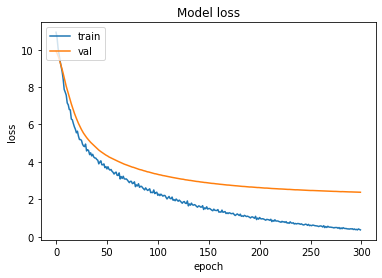

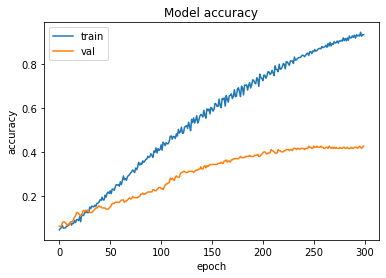

In [20]:
plot_history(step2_history, 'loss')
plot_history(step2_history, 'accuracy')

When allowing the parameters of the base model to be modified as well, we add a large amount of capacity to the model which leads to a strong overfit. Now the model experiences high variance and rather low bias (the train accuracy has not converged yet). Data augmentation, Dropout or weight regularizers could help to adress those problems.

## Test the fine-tuned model

In [21]:
%%time
# Predict the test set
y_pred = model1.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

78/78 [==============================] - 6s 74ms/step
CPU times: user 53.2 s, sys: 1.98 s, total: 55.2 s
Wall time: 11.7 s


In [22]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.6230893000804505
CPU times: user 2.01 ms, sys: 79 µs, total: 2.09 ms
Wall time: 1.38 ms


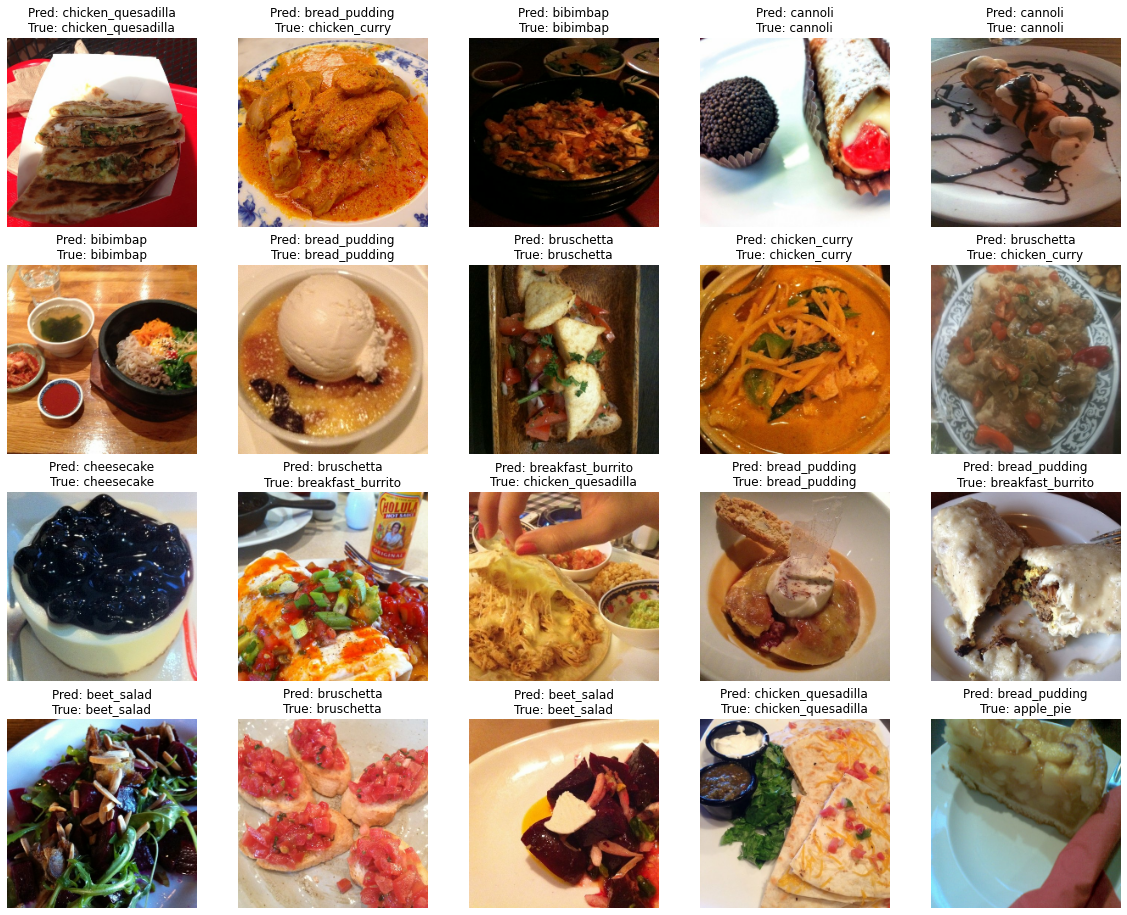

In [23]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)